# ChatBot with Message Summarization

In [1]:
# This notebook constructs a simple chatbot that does the following tasks:
#1. uses a persistence layer to confer memory (MemorySaver)
#2. can summarize old messages but retains their summary
#3. removes the old messages if greater than arbitrary number (set to 5)
#4. is tracked in LangSmith

# Created Oct 10, 2025

### Load Env Variables

In [1]:
# Load needed environment variables
# By default, load_dotenv() looks for .env in the current directory.
# You can specify a path if your .env file is elsewhere:
# load_dotenv(dotenv_path='/path/to/your/.env')

import os
from dotenv import load_dotenv

load_dotenv()

#Loads the needed env variables into the current notebook session
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
LANGSMITH_API_KEY = os.environ.get("LANGSMITH_API_KEY")
LANGSMITH_TRACING_V2 = os.environ.get("LANGSMITH_TRACING_V2")
LANGSMITH_PROJECT = os.environ.get("LANGSMITH_PROJECT")
LANGSMITH_ENDPOINT = os.environ.get("LANGSMITH_ENDPOINT")

In [2]:
# Check that the API key is in place
# Expected behavior: nothing if cell above worked, 
# otherwise will get a window for entry.
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        print("The OPENAI_API_KEY is not found")
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

### Create Model and Class Object

In [3]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState

model = ChatOpenAI(model="gpt-5-nano",temperature=0)

class BotState(MessagesState):
    summary: str

### Define Nodes

In [10]:
# Define a node to call our LLM that incorporates a summary, if it exists,
# into the prompt.

from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

# Define the logic to call the model
def call_model(state: BotState):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

In [11]:
# Define a node to produce a summary
# This includes RemoveMessage

def summarize_conversation(state: BotState):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

### Define a Conditional Edge

In [12]:
from langgraph.graph import END
from typing_extensions import Literal

# Determine whether to end or summarize the conversation
def should_continue(state: BotState) -> Literal ["summarize_conversation",END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than five messages, then summarize the conversation
    if len(messages) > 5:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

### Define the Graph

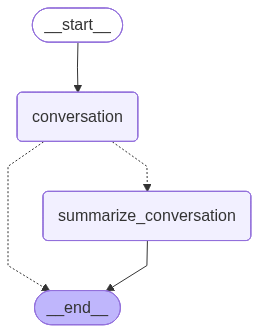

In [13]:
## NOTE: using MemorySaver to confer memory

from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(BotState)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Use the ChatBot in a Thread

In [14]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="Hi, I am a data scientist")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="I used to work for Cirlcle K")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="My name is Rich")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()
    
input_message = HumanMessage(content="I like to play pickleball")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()
    
input_message = HumanMessage(content="I built a community at work who would come play pickleball at lunch once a week")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()
input_message = HumanMessage(content="Who did I work for and what's my occupation?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Nice to meet you! How can I help today? As a data scientist, you might find these useful:

- Problem framing and experimental design (defining metrics, baselines, cross-validation, A/B testing)
- Feature engineering ideas and data cleaning tips
- Model selection and hyperparameter tuning (scikit-learn, XGBoost, LightGBM, PyTorch, etc.)
- Code support (Python, R, SQL) and reproducible pipelines
- Model evaluation, diagnostics, and overfitting checks
- Interpretability and communication (SHAP/LIME, feature importance)
- Deployment and MLOps basics (pipelines, versioning, Docker, MLflow)
- Time series, anomaly detection, NLP tasks

If you share a dataset, a problem statement, or the tooling you prefer, I can propose a plan, provide sample code, and outline a concrete evaluation strategy. Would you like a quick starting checklist or a template notebook to begin with?
================================== Ai Mess